Start this on the zedboard first
```bash
$ sudo python3 litex_server.py --devmem --devmem-offset 0x40000000
```

In [245]:
%pylab notebook
from struct import pack, unpack
from time import sleep
import sys
sys.path.append("../..")
from common import *
from scope_app import autoBitslip, autoIdelay, getSamples
from matplotlib.animation import FuncAnimation
rcParams["axes.grid"] = True

Populating the interactive namespace from numpy and matplotlib


# Setup SPI, reset and dump LTC2175 registers

In [246]:
r = conLitexServer('../build/csr.csv')
print("f_sample:", r.regs.lvds_f_sample_value.read() / 1e6, "MHz")

Connected to Port 1234
Zedboard RF vector volt-meter 2019-11-11 12:05:10
f_sample: 4.387912 MHz


In [48]:
ltc_spi = LTC_SPI(r)
for i in range(5):
    print("{:2x}: {:02x}".format(i, ltc_spi.get_ltc_reg(i)))

ltc_spi.set_ltc_reg(0, 0x80)   # Software reset
# ltc_spi.set_ltc_reg(1, 0x10)   # Sleep mode
# ltc_spi.set_ltc_reg(1, 0x00)   # Waky waky

ltc_spi.setTp(1)
autoBitslip(r)
autoIdelay(r)

ltc_spi.set_ltc_reg(3, 0)   # Test pattern off
ltc_spi.set_ltc_reg(1, (1 << 5))   # Randomizer off, twos complement output

 0: 00
 1: 00
 2: 00
 3: 00
 4: 00


RuntimeError: autoBitslip(): failed alignment :(

# Play with bitslip / idelay parameters

### show status

In [4]:
def print_frm():
    idel = r.regs.lvds_idelay_value.read()
    v = r.regs.lvds_frame_peek.read()
    print("ID: {:}  F: {:08b}".format(idel, v))
    for i in range(4):
        v = getattr(r.regs, 'lvds_data_peek{:}'.format(i)).read()
        print("{:}: {:016b}".format(i, v))
ltc_spi.setTp(1)
print_frm()

ID: 15  F: 11110000
0: 0000000000000001
1: 0000000000000001
2: 0000000000000001
3: 0000000000000001


### bitslip until we get 0xF0 on frame_peek

In [ ]:
r.regs.lvds_bitslip_csr.write(1)
print_frm()

### IDELAY adjustments to find the eye limits

In [ ]:
r.regs.lvds_idelay_inc.write(1)
print_frm()

In [ ]:
r.regs.lvds_idelay_dec.write(1)
print_frm()

do a bitslip until we get 0x0F

### map data lanes
Check that each bit in the test-pattern end up in the right place in the output word

In [ ]:
for ch in range(4):
    print("Channel {:d}".format(ch))
    for i in range(14):
        tpValue = 1 << i
        ltc_spi.setTp(tpValue)
        rVal = getattr(r.regs, 'lvds_data_peek{:d}'.format(ch)).read()
        print("{:016b} {:016b}".format(tpValue, rVal))    

# Read ADC sample

In [5]:
ltc_spi.set_ltc_reg(3, 0)   # Test pattern off
ltc_spi.set_ltc_reg(1, (1 << 5))   # Randomizer off, twos complement output

In [8]:
# Lowest 2 bits are always zero in 16 bit LVDS mode
# 12 bit ADC, so next 2 bits are also zero
rVal = r.regs.lvds_data_peek0.read()
print("0x{0:04x} 0b{0:016b}".format(rVal))
# Decode offset binary mode
print(twos_comp(rVal, 14))

0x0139 0b0000000100111001
313


# Read randomized ADC sample

In [ ]:
ltc_spi.set_ltc_reg(1, (1<<6))   # Randomizer on

In [ ]:
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# XOR LSB with any other bit
if rVal & 0x01:
    rVal ^= 0xFFE
# Decode offset binary mode
print(rVal - (1 << 11))

# Read acquisition memory

In [11]:
hd(r.big_read(0x10000000, 0x400), 2, 1)


0000: 01a5 00bd 3e55 3f63 01b8 0088 3e47 3f98 
0008: 01c6 004f 3e37 3fcd 01ce 0019 3e32 0009 
0010: 01cf 3fe2 3e35 003e 01c9 3fa9 3e3f 0075 
0018: 01bd 3f74 3e4f 00ac 01ac 3f3d 3e64 00dd 
0020: 0190 3f0e 3e80 010f 0171 3ee1 3ea3 0138 
0028: 014d 3eb6 3ecb 0160 0125 3e90 3ef4 0183 
0030: 00f8 3e74 3f25 019e 00c7 3e5b 3f58 01b5 
0038: 0092 3e48 3f8b 01c5 005d 3e3a 3fc5 01ce 
0040: 0023 3e35 3ffe 01d1 3fec 3e36 0033 01ca 
0048: 3fb3 3e3d 006c 01c1 3f7e 3e4c 00a0 01af 
0050: 3f47 3e63 00d2 0196 3f16 3e79 0105 0179 
0058: 3eeb 3e9b 0131 0158 3ebe 3ec4 015a 012d 
0060: 3e9a 3eed 017c 0101 3e79 3f1c 0199 00d0 
0068: 3e5e 3f4e 01b0 009e 3e4a 3f82 01c2 0066 
0070: 3e3f 3fba 01cc 002e 3e35 3fef 01d0 3ff7 
0078: 3e34 0027 01cc 3fbe 3e3c 0060 01c4 3f89 
0080: 3e4a 0096 01b4 3f54 3e5f 00c8 019e 3f23 
0088: 3e75 00fd 017f 3ef2 3e93 0127 015d 3ec7 
0090: 3eba 0151 0136 3ea0 3ee3 0174 0109 3e7f 
0098: 3f13 0194 00d8 3e65 3f43 01ac 00a8 3e4f 
00a0: 3f74 01be 0071 3e3f 3fb0 01ca 003a 3e35 
00a8: 3fe4 0

In [10]:
r.regs.acq_trig_level.write(0)
print(hex(r.regs.acq_trig_level.read()))
r.regs.acq_trig_csr.write(1)

0x0


<IPython.core.display.Javascript object>


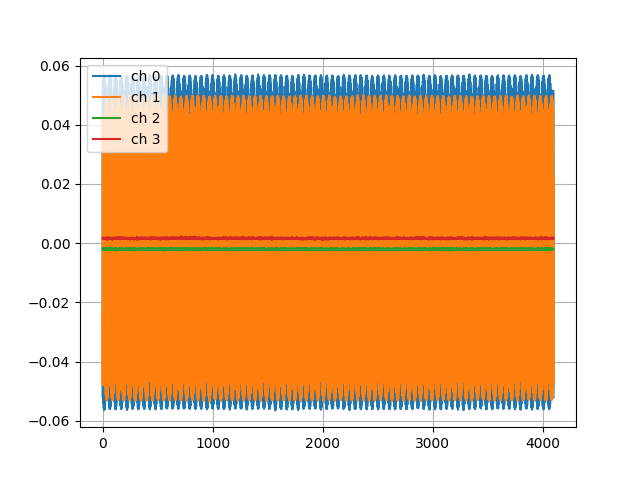

In [12]:
close('all')
for i in range(4):
#     dat = array(r.big_read(0x10000000 + i * 0x01000000, 0x1000))
#     dat = twos_comps(dat >> 2, 14)
    dat = getSamples(r, i, 0x1000)
    plot(dat, label='ch ' + str(i), drawstyle='steps-post')
legend()

In [13]:
r.regs.ctrl_bus_errors.read()

0

# Vector volt-meter

### Setup

In [37]:
# Frequency / bandwidth setting
deci = 100  # decimation factor
f_sample = r.regs.lvds_f_sample_value.read()  # Sampling clock frequency
f_ref = r.regs.vvm_f_ref_value.read()  # Zero crossing frequency counter on adc0
# ftw = int(((f_rf / f_sample) % 1) * 2**32)
ftw = int(f_ref / f_sample * 2**32)
r.regs.vvm_ddc_ftw.write(ftw)
r.regs.vvm_ddc_deci.write(deci)

# Throw away N bits after CIC to avoid saturation with large deci factors
# This will change the scaling!
r.regs.vvm_ddc_shift.write(0)

# IIR result averaging filter smoothing factor (0 - 15)
r.regs.vvm_iir.write(15)

print('ddc_ftw', hex(r.regs.vvm_ddc_ftw.read()))
print('f_sample', f_sample)
print('f_ref', f_ref)
print('ddc_deci', r.regs.vvm_ddc_deci.read())
print('bw', f_sample / deci)
print('iir_shift', r.regs.vvm_iir.read())

ddc_ftw 0x416b4e3c
f_sample 117600580
f_ref 30052076
ddc_deci 100
bw 1176005.8
iir_shift 15


### Text mode

In [60]:
print("Magnitude")
for i in range(4):
    print(getattr(r.regs, "vvm_mag{}".format(i)).read() / (1 << 21))
print("\nPhase")
for i in range(4):
    print(getInt32(getattr(r.regs, "vvm_phase{}".format(i)).read()) / (1 << 21))

Magnitude
0.111236572265625
0.1015005111694336
5.14984130859375e-05
5.1021575927734375e-05

Phase
0.5238509178161621
0.7776632308959961
-0.7786545753479004
-0.39915895462036133


### Plot recorded time series

<IPython.core.display.Javascript object>


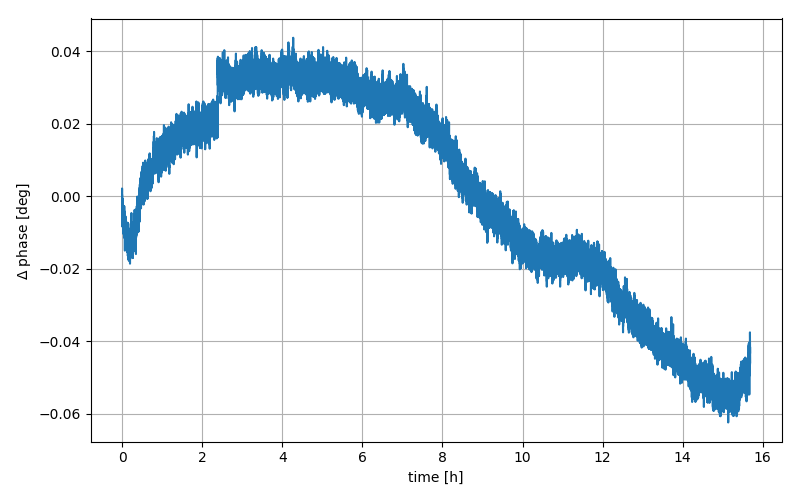

In [41]:
fName = "overnight_phase_22bit_1Hz.npz"
d = load(fName)['dat'][300:]
fig, ax = subplots(figsize=(8,5))
ax.plot(arange(len(d)) / 60 / 60, d - mean(d))
ax.set_xlabel('time [h]')
ax.set_ylabel('$\Delta$ phase [deg] ')
tight_layout()
savefig(fName.split('.')[0] + '.png', dpi=200)

# Demonstrate bit - mapping ...
of serdes lane bits to ADC sample words

In [54]:
N_CHANNELS = 4
S = 8
D = N_CHANNELS * 2 + 1
data_outs = [arange(i * S, (i + 1) * S) for i in range(D)]
for i, d in enumerate(data_outs):
    print("lane", i, "bit", d)
print()
for i in range(N_CHANNELS):
    print("channel", i, myzip(data_outs[2 * i + 1], data_outs[2 * i])[2:])

lane 0 bit [0 1 2 3 4 5 6 7]
lane 1 bit [ 8  9 10 11 12 13 14 15]
lane 2 bit [16 17 18 19 20 21 22 23]
lane 3 bit [24 25 26 27 28 29 30 31]
lane 4 bit [32 33 34 35 36 37 38 39]
lane 5 bit [40 41 42 43 44 45 46 47]
lane 6 bit [48 49 50 51 52 53 54 55]
lane 7 bit [56 57 58 59 60 61 62 63]
lane 8 bit [64 65 66 67 68 69 70 71]

channel 0 [9, 1, 10, 2, 11, 3, 12, 4, 13, 5, 14, 6, 15, 7]
channel 1 [25, 17, 26, 18, 27, 19, 28, 20, 29, 21, 30, 22, 31, 23]
channel 2 [41, 33, 42, 34, 43, 35, 44, 36, 45, 37, 46, 38, 47, 39]
channel 3 [57, 49, 58, 50, 59, 51, 60, 52, 61, 53, 62, 54, 63, 55]


# I2C bit-banging for Si570 setup

In [51]:
r.regs.vvm_si570_oe.write(1)  # RF on / off switch 

In [209]:
class BB_I2C:
    def __init__(self, r, w):
        self.r = r
        self.w = w
        self.w.write(1)  # SCL = 1, OE = 0, SDA = 0
        self.SCL = 1
        self.SDA = 1
        
    def set_pins(self, scl=None, sda=None):
        if scl is not None:
            self.SCL = scl
        if sda is not None:
            self.SDA = sda
        self.w.write((0 if self.SDA else 2) | (self.SCL & 1))

    def start(self):
        self.set_pins(scl=1, sda=1)
        self.set_pins(scl=1, sda=0)
        self.set_pins(scl=0, sda=0)
        
    def stop(self):
        self.set_pins(scl=1, sda=0)
        self.set_pins(scl=1, sda=1)
        
    def tx(self, dat):
        for i in range(8):
            self.set_pins(sda=(dat & 0x80))
            self.set_pins(scl=1)
            dat <<= 1
            self.set_pins(scl=0)
        # Receive ack from slave
        self.set_pins(sda=1)
        self.set_pins(scl=1)
        ack = self.r.read() == 0
        self.set_pins(scl=0)
        return ack
    
    def rx(self, ack):
        dat = 0
        for i in range(8):
            dat <<= 1
            self.set_pins(scl=1)
            dat |= self.r.read()
            self.set_pins(scl=0)
        # Send ACK to slave       
        self.set_pins(sda=(ack == 0))
        self.set_pins(scl=1)
        self.set_pins(scl=0, sda=1)
        return dat
        
    def write_regs(self, addr_7, addr_reg, data):
        ret = 1
        self.start()
        ret &= self.tx((addr_7 << 1))
        ret &= self.tx(addr_reg)
        for d in data:
            ret &= self.tx(d)
        self.stop()
        return ret
    
    def read_regs(self, addr_7, addr_reg, N):
        ret = 1
        self.start()
        ret &= self.tx((addr_7 << 1))
        ret &= self.tx(addr_reg)
        self.start()
        ret &= self.tx((addr_7 << 1) | 1)
        dat = []
        for i in range(N):
            dat.append(self.rx(i < (N - 1)))
        self.stop()
        return dat

In [248]:
i2c = BB_I2C(r.regs.vvm_si570_i2c_r, r.regs.vvm_si570_i2c_w)

In [250]:
i2c.write_regs(0x55, 0x0D, [0xA0, 0xC2, 0xF4, 0x54, 0x6B, 0x22])

1

In [254]:
hd(i2c.read_regs(0x55, 0x0D, 6))

ad 42 a8 b2 60 6c 


In [197]:
sys.path.append("/home/michael/fpga_wsp/Si5xx-5x7-EVV_autoloader/")
from Si570 import Si570
from setFreq import getDividers

In [252]:
si = Si570("r ad 42 a8 b2 60 6c")

fxtal = si.fxtal(10e6)
hs_div, n1, fDco = getDividers(150e6)

rffreq = fDco / fxtal
silNew = Si570();
silNew.HS_DIV = hs_div
silNew.N1 = n1
silNew.RFFREQ = rffreq

silNew

w A0 C2 F4 54 6B 22

```C
    //Freeze the DCO
    ret &= i2c_write_reg( SI570_ADDR, FREEZE_DCO_REG, SI570_FREEZE_DCO );
    //Write all 6 registers
    ret &= i2c_write_regs(SI570_ADDR, REG_OFFS, buf, 6 );
    //Unfreeze the DCO
    ret &= i2c_write_reg( SI570_ADDR, FREEZE_DCO_REG, 0 );
    //assert the NewFreq bit
    ret &= i2c_write_reg( SI570_ADDR, CTRL_REG, SI570_NEW_FREQ );
```

In [253]:
FREEZE_DCO_REG = 137
SI570_FREEZE_DCO = (1 << 4)
CTRL_REG = 135
SI570_NEW_FREQ = (1 << 6)
i2c.write_regs(0x55, FREEZE_DCO_REG, [SI570_FREEZE_DCO])
# i2c.write_regs(0x55, 0x0D, [0xad, 0x42, 0xa8, 0xb2, 0x60, 0x6c])
i2c.write_regs(0x55, 0x0D, [0xA0, 0xC2, 0xF4, 0x54, 0x6B, 0x22])
i2c.write_regs(0x55, FREEZE_DCO_REG, [0])
i2c.write_regs(0x55, CTRL_REG, [SI570_NEW_FREQ])

1